<a href="https://colab.research.google.com/github/brendanpshea/database_sql/blob/main/Database_03_Joins_Sets_SQL.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Getting Tables Together With Joins and Sets
### Brendan Shea, PhD

In this chapter, we dive into the powerful world of SQL joins and set operations. We'll explore how these tools allow us to combine data from multiple tables in a database, enabling us to extract meaningful insights and answer complex questions. Using a database based on data from the Internet Movie Database (IMDB), we'll learn how to connect related pieces of information, such as movies, actors, directors, and awards. By mastering joins and set operations, you'll be able to navigate and manipulate relational databases with ease.

Learning Outcomes:

-   Understand the concept of joins and how they combine data from multiple tables
-   Learn about different types of joins: INNER JOIN, LEFT JOIN, RIGHT JOIN, and FULL OUTER JOIN
-   Use SQL set operations like UNION, INTERSECT, and EXCEPT to combine result sets
-   Write SQL queries that involve multiple joins and set operations
-   Analyze a database schema and create an entity-relationship diagram (ERD)
-   Apply joins and set operations to solve real-world problems and answer questions about data

Keywords: SQL, joins, set operations, UNION, INTERSECT, EXCEPT, database schema, entity-relationship diagram

## Brendan's Lecture
Run the following cell to see my lecture.

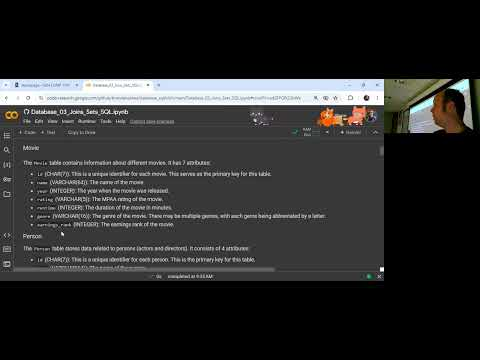

In [6]:
##Click here to launch my lecture
from IPython.display import YouTubeVideo
YouTubeVideo('Ke85ZO628qU', width=800, height=500)

## Introduction to the Movie Database
For this chapter, we'll be using a database based on data from the Internet Movie Database (IMDB). The full dataset is available here: https://developer.imdb.com/non-commercial-datasets/. We'll just be using a small part of this data, based on movies that have (at one point or another) been in the "top 100" in terms of box office returns.

To start off with, we need to download a copy of the database and connect to it:

In [7]:
# Now let's download the file we'll be using for this lab
!wget 'https://github.com/brendanpshea/database_sql/raw/main/data/movie.sqlite' -q -nc

!pip install prettytable==0.7.2 --force-reinstall -q
%reload_ext sql
%config SqlMagic.autopandas=True
%sql sqlite:///movie.sqlite

  Preparing metadata (setup.py) ... done


## Database Schema: Movies
Let's begin by exploring the **database schem** for movies.db. This will give us:

1. A list of all the tables in the datase.
2. The columns (attributes) of each table.
3. The primary and foreign keys that link the tables together.

We can do this by typing the following command:

In [8]:
%%sql
SELECT *
FROM sqlite_schema
WHERE type = 'table';-- Show the database schema

 * sqlite:///movie.sqlite
Done.


,type,name,tbl_name,rootpage,sql
0,table,Movie,Movie,2,"CREATE TABLE Movie (id CHAR(7) PRIMARY KEY, na..."
1,table,Person,Person,4,"CREATE TABLE Person (id CHAR(7) PRIMARY KEY, n..."
2,table,Actor,Actor,11,"CREATE TABLE Actor (actor_id CHAR(7), movie_id..."
3,table,Director,Director,15,"CREATE TABLE Director(director_id CHAR(7), mov..."
4,table,Oscar,Oscar,18,"CREATE TABLE Oscar(movie_id CHAR(7), person_id..."


Our database consists of five tables: Movie, Person, Actor, Director, and Oscar. These tables store data related to movies, persons (actors and directors), and Oscar awards. Now, let's explore each of these tables, their attributes, data types, and primary keys.

#### Movie
The `Movie` table contains information about different movies. It has 7 attributes:

-   `id` (CHAR(7)): This is a unique identifier for each movie. This serves as the primary key for this table.
-   `name` (VARCHAR(64)): The name of the movie.
-   `year` (INTEGER): The year when the movie was released.
-   `rating` (VARCHAR(5)): The MPAA rating of the movie.
-   `runtime` (INTEGER): The duration of the movie in minutes.
-   `genre` (VARCHAR(16)): The genre of the movie. There may be multiple genres, with each genre being abbreviated by a letter.
-   `earnings_rank` (INTEGER): The earnings rank of the movie.


#### Person
The `Person` table stores data related to persons (actors and directors). It consists of 4 attributes:

-  `id` (CHAR(7)): This is a unique identifier for each person. This is the primary key for this table.
-   `name` (VARCHAR(64)): The name of the person.
-   `dob` (DATE): The date of birth of the person.
-   `pob` (VARCHAR(128)): The place of birth of the person.


#### Actor and Director
The `Actor` and `Director` tables are **junction tables** (or **join tables**) which store the relationship between movies and persons (actors or directors). A join table is used to resolve many-to-many relationships by breaking it down into two one-to-many relationships. In this case, a movie can have multiple actors and a person can act in multiple movies. Same applies for directors. Each of these tables has two attributes:

-   `actor_id/director_id` (CHAR(7)): This refers to the id of the person who is an actor/director. This forms part of the composite primary key.
-   `movie_id` (CHAR(7)): This refers to the id of the movie. This also forms part of the composite primary key.

4\. Oscar: This table stores information about Oscar awards. It contains 4 attributes:

-   `movie_id` (CHAR(7)): This refers to the id of the movie that won an Oscar.
-   `person_id` (CHAR(7)): This refers to the id of the person who won an Oscar.
-   `type` (VARCHAR(23)): This represents the type of Oscar award.
-   `year` (INTEGER): The year when the Oscar was awarded.

The key for this table is a combination of `person_id`, `type`, and `year` columns.

## A "Crow's Foot" Entity-Relationship Diagram of the Movie Data
To help us better understand the stucture of the movie data, let's create an **entity-relationship** diagram. Here, I am using **Crow's Foot** style (more on this later). I'm using the Mermaid language to create the diagram.

In [9]:
# @title
import base64
from IPython.display import Image, display, HTML

def mm(graph):
    graphbytes = graph.encode("utf8")
    base64_bytes = base64.b64encode(graphbytes)
    base64_string = base64_bytes.decode("ascii")
    display(Image(url="https://mermaid.ink/img/" + base64_string))

mm("""
erDiagram
    MOVIE {
        CHAR(7) id PK
        VARCHAR(64) name
        INTEGER year
        VARCHAR(5) rating
        INTEGER runtime
        VARCHAR(16) genre
        INTEGER earnings_rank
    }

    PERSON {
        CHAR(7) id PK
        VARCHAR(64) name
        DATE dob
        VARCHAR(128) pob
    }

    ACTOR {
        CHAR(7) actor_id  PK, FK
        CHAR(7) movie_id  PK, FK
    }

    DIRECTOR {
        CHAR(7) director_id PK, FK
        CHAR(7) movie_id  PK, FK
    }

    OSCAR {
        CHAR(7) movie_id  FK
        CHAR(7) person_id  PK, FK
        VARCHAR(23) type PK
        INTEGER year  PK
    }

    MOVIE ||--o{ ACTOR : movie_has_actor
    MOVIE ||--o{ DIRECTOR : movie_directed_by_director
    PERSON ||--o{ ACTOR : actor_is_a_person
    PERSON ||--o{ DIRECTOR : director_is_a_person
    MOVIE ||--o{ OSCAR : movie_wins_oscar
    PERSON ||--o{ OSCAR : person_wins_oscar
""")

## Interpreting a Crow's Foot ERD
Crow's foot diagrams, also known as Entity-Relationship Diagrams (ERDs), are a popular way to visually represent the structure and relationships of a database. Let's break down the components of the diagram and understand how to interpret it.

### Entities
  -   Entities are represented by rectangles and denote the main objects or concepts in the database.
  -   In this diagram, the entities are MOVIE, PERSON, ACTOR, DIRECTOR, and OSCAR.
  -   Each entity has its own set of attributes, which are listed inside the rectangle.

### Attributes
  -   Attributes represent the properties or characteristics of an entity.
  -   They are listed inside the entity's rectangle, along with their data types.
  -   For example, the MOVIE entity has attributes like id (CHAR(7)), name (VARCHAR(64)), year (INTEGER), rating (VARCHAR(5)), runtime (INTEGER), genre (VARCHAR(16)), and earnings_rank (INTEGER).
  -   The attribute followed by "PK" indicates the primary key of the entity, which uniquely identifies each record.
  -   The attribute followed by "FK" indicates a foreign key, which establishes a relationship with another entity.


### Relationships
  -   Relationships between entities are represented by lines connecting the rectangles.
  -   The **cardinality** (number of entities parcipating) of a relationship is indicated by the symbols at each end of the line.
  -   The **crow's foot symbol** (three lines) represents a "many" relationship, while a single line represents a "one" relationship.
  -   An optional relationship is denoted by a circle (o), while a mandatory relationship is denoted by a vertical line (|).

### Join Tables
  -   **Join tables** are used to establish many-to-many relationships between entities.
  -   In this diagram, the ACTOR and DIRECTOR tables are join tables that connect the MOVIE and PERSON tables.
  -   The ACTOR table has a **composite primary key** consisting of actor_id (referencing the id in the PERSON table) and movie_id (referencing the id in the MOVIE table).
  -   Similarly, the DIRECTOR table has a composite primary key consisting of director_id (referencing the id in the PERSON table) and movie_id (referencing the id in the MOVIE table).


### Interpreting the Relationships:
  -   MOVIE ||--o{ ACTOR : movie_has_actor
      -   This relationship indicates that a movie can have multiple actors, and an actor can be in multiple movies.
      -   The ACTOR table is a join table that establishes this many-to-many relationship between MOVIE and PERSON.
      -   The crow's foot symbol on the ACTOR end indicates that multiple actors can be associated with a movie.
  -   MOVIE ||--o{ DIRECTOR : movie_directed_by_director
      -   This relationship indicates that a movie can have multiple directors, and a director can direct multiple movies.
      -   The DIRECTOR table is a join table that establishes this many-to-many relationship between MOVIE and PERSON.
      -   The crow's foot symbol on the DIRECTOR end indicates that multiple directors can be associated with a movie.
  -   PERSON ||--o{ ACTOR : actor_is_a_person
      -   This relationship indicates that an actor is a person, and a person can be an actor.
      -   The crow's foot symbol on the ACTOR end indicates that a person can be associated with multiple movies as an actor.
  -   PERSON ||--o{ DIRECTOR : director_is_a_person
      -   This relationship indicates that a director is a person, and a person can be a director.
      -   The crow's foot symbol on the DIRECTOR end indicates that a person can be associated with multiple movies as a director.
  -   MOVIE ||--o{ OSCAR : movie_wins_oscar
      -   This relationship indicates that a movie can win multiple Oscars, and an Oscar is associated with a movie.
      -   It is optional for a movie to win an Oscar.
  -   PERSON ||--o{ OSCAR : person_wins_oscar
      -   This relationship indicates that a person can win multiple Oscars, and an Oscar is associated with a person.
      -   It is optional for a person to win an Oscar.

### Previewing the Data
Finally, let's use some simple SQL `SELECT` statements to take a look at the data.

The basic `SELECT *` statement retrieves all columns from a table. The `*` is a wildcard that means "all columns." The `LIMIT` clause restricts the number of rows returned - in this case, we'll see only the first 10 rows of the Movie table.

In [10]:
%%sql
SELECT *
FROM Movie
LIMIT 10;

 * sqlite:///movie.sqlite
Done.


,id,name,year,rating,runtime,genre,earnings_rank
0,2488496,Star Wars: The Force Awakens,2015,PG-13,138,A,1
1,4154796,Avengers: Endgame,2019,PG-13,181,AVS,2
2,1087260,Spider-Man: No Way Home,2021,PG-13,148,AVFS,3
3,0499549,Avatar,2009,PG-13,162,AVYS,4
4,1745960,Top Gun: Maverick,2022,PG-13,130,AD,5
5,1825683,Black Panther,2018,PG-13,134,AVS,6
6,4154756,Avengers: Infinity War,2018,PG-13,149,AVYS,7
7,0120338,Titanic,1997,PG-13,194,DR,8
8,0369610,Jurassic World,2015,PG-13,124,A,9
9,0848228,The Avengers,2012,PG-13,143,A,10


This query introduces several aggregate functions:
- `COUNT(DISTINCT id)` counts unique movie IDs, eliminating duplicates
- `MIN()` and `MAX()` find the smallest and largest values in a column
- `AVG()` calculates the mean value
- `ROUND(x, n)` rounds number x to n decimal places
Each column is given an alias using the `AS` keyword to make the output more readable.


In [11]:
%%sql
-- Statics about Movies
SELECT
  COUNT(DISTINCT id) AS "num_movies",
  MIN(year) AS "earliest_year",
  MAX(year) AS "latest_year",
  MIN(runtime) AS "shortest_movie",
  MAX(runtime) AS "longest_movie",
  ROUND(AVG(runtime),2) AS "avg_movie_runtime"
FROM Movie;

 * sqlite:///movie.sqlite
Done.


,num_movies,earliest_year,latest_year,shortest_movie,longest_movie,avg_movie_runtime
0,745,1927,2022,66,242,121.88


Another `SELECT *` query, showing us all columns from the Person table. Like before, `LIMIT 10` ensures we only see the first 10 rows, making the output manageable.

In [12]:
%%sql
SELECT *
FROM Person
LIMIT 10;

 * sqlite:///movie.sqlite
Done.


,id,name,dob,pob
0,0000002,Lauren Bacall,1924-09-16,"New York, New York, USA"
1,0000004,John Belushi,1949-01-24,"Chicago, Illinois, USA"
2,0000006,Ingrid Bergman,1915-08-29,"Stockholm, Sweden"
3,0000007,Humphrey Bogart,1899-12-25,"New York, New York, USA"
4,0000008,Marlon Brando,1924-04-03,"Omaha, Nebraska, USA"
5,0000009,Richard Burton,1925-11-10,"Pontrhydyfen, Wales, UK"
6,0000010,James Cagney,1899-07-17,"Yonkers, New York, USA"
7,0000011,Gary Cooper,1901-05-07,"Helena, Montana, USA"
8,0000012,Bette Davis,1908-04-05,"Lowell, Massachusetts, USA"
9,0000014,Olivia de Havilland,1916-07-01,"Tokyo, Japan"


Here we use `COUNT(DISTINCT id)` to count unique person IDs. The `DISTINCT` keyword ensures we don't count any person more than once, even if they appear multiple times in the table.

In [13]:
%%sql
-- Number of disticnt people
SELECT
  COUNT(DISTINCT id) AS "num_people"
FROM Person

 * sqlite:///movie.sqlite
Done.


,num_people
0,2672


Looking at the Actor junction table with `SELECT *`. This shows us how actors are connected to movies through their IDs. The `LIMIT 5` clause shows just the first 5 rows.

In [14]:
%%sql
SELECT *
FROM Actor
LIMIT 5;

 * sqlite:///movie.sqlite
Done.


,actor_id,movie_id
0,0000138,0120338
1,0000701,0120338
2,0000708,0120338
3,0000870,0120338
4,0000200,0120338


Using `COUNT(DISTINCT actor_id)` to count unique actors. Remember that `DISTINCT` eliminates duplicates, so actors who appear in multiple movies are only counted once.

In [15]:
%%sql
--Number of actors
SELECT COUNT(DISTINCT actor_id) AS "num_actors"
FROM Actor

 * sqlite:///movie.sqlite
Done.


,num_actors
0,2239


Another look at a junction table, this time for directors. The `SELECT *` shows all columns, while `LIMIT 5` keeps the output brief.


In [16]:
%%sql
SELECT *
FROM Director
LIMIT 5;

 * sqlite:///movie.sqlite
Done.


,director_id,movie_id
0,0000116,0120338
1,0000184,0076759
2,0011470,0298148
3,0000229,0083866
4,0000184,0120915


Similar to our actor count, `COUNT(DISTINCT director_id)` gives us the number of unique directors in our database.


In [17]:
%%sql
--Number of directors
SELECT COUNT(DISTINCT director_id) AS "num_directors"
FROM Director

 * sqlite:///movie.sqlite
Done.


,num_directors
0,433


Examining the Oscar table with `SELECT *`. The `LIMIT 5` clause shows us a sample of the award records.

In [18]:
%%sql
SELECT *
FROM Oscar
LIMIT 5;

 * sqlite:///movie.sqlite
Done.


,movie_id,person_id,type,year
0,1036646,None,BEST-PICTURE,2022
1,9620288,0000226,BEST-ACTOR,2022
2,9115530,1567113,BEST-ACTRESS,2022
3,3581652,3663196,BEST-SUPPORTING-ACTRESS,2022
4,1036646,1319274,BEST-SUPPORTING-ACTOR,2022


The `SELECT DISTINCT type` query shows all unique values in the type column, with no duplicates. This tells us all the different categories of Oscars in our database.

In [19]:
%%sql
--Types of Oscars
SELECT DISTINCT type
FROM Oscar

 * sqlite:///movie.sqlite
Done.


,type
0,BEST-PICTURE
1,BEST-ACTRESS
2,BEST-SUPPORTING-ACTRESS
3,BEST-ACTOR
4,BEST-SUPPORTING-ACTOR
5,BEST-DIRECTOR


## A Gentle Introduction to JOINs
The `Movie` table contains information about each movie, such as its name, year of release, rating, runtime, genre, and earnings rank. The `Person` table contains information about people involved in the movies, including their name, date of birth, and place of birth.

But what if you wanted to know which actors appeared in which movies or who directed a particular movie? This information is not directly in either the `Movie` or `Person` table. That's where JOINs come in! JOINs allow you to combine rows from two or more tables based on a related column between them.

In this database, the `Actor` and `Director` tables serve as junction tables (also known as join tables). They establish the many-to-many relationships between movies and persons. Each row in the `Actor` table links a particular person to a particular movie they acted in, while each row in the `Director` table links a person to a movie they directed.

To perform a JOIN, you need to specify:

1.  The tables you want to join
2.  The columns that relate the two tables

In this schema, the `id` column in the `Movie` table is the primary key, and the `movie_id` columns in the `Actor` and `Director` tables are foreign keys. Similarly, the `id` column in the `Person` table is the primary key, and the `actor_id` and `director_id` columns in the `Actor` and `Director` tables are foreign keys.

Here's how you would JOIN the `Movie` and `Actor` tables to find out which actors appeared in which movies:

```sql
`SELECT *
FROM Movie
JOIN Actor ON Movie.id = Actor.movie_id;
```

And here's how you would JOIN the `Actor` and `Person` tables to get the names of the actors:

```sql
SELECT *
FROM Actor
JOIN Person ON Actor.actor_id = Person.id;
```

By default, SQL uses an INNER JOIN. An INNER JOIN returns only the rows where there is a match in both tables. So if a movie doesn't have any actors listed in the `Actor` table, that movie will not appear in the result. Similarly, if a person hasn't acted in any movies according to the `Actor` table, that person will not appear in the result.

You can also join multiple tables. For example, to get the names of all the actors in a specific movie:

```sql
SELECT Person.name
FROM Movie
JOIN Actor ON Movie.id = Actor.movie_id
JOIN Person ON Actor.actor_id = Person.id
WHERE Movie.name = 'Insert Movie Name';
```

Or to find out who directed a particular movie:

```sql
SELECT Person.name
FROM Movie
JOIN Director ON Movie.id = Director.movie_id
JOIN Person ON Director.director_id = Person.id
WHERE Movie.name = 'Insert Movie Name';
```

JOINs are a powerful tool for working with data spread across related tables. They allow you to combine information in ways not possible with individual tables. Mastering JOINs is a key skill for working with relational databases like SQLite.



### Example: JOINing Movie and Actor

In the `Movie` table, the primary key is `id`. Both the `Person` and the `Actor` table have an attribute called `movie_id` that is a foreign that links to the is. So, we could write joins like this:

In [20]:
%%sql
SELECT
  -- We can select columns from multiple tables
  Movie.name,
  Actor.actor_id
FROM
  -- Here we join the Movie and Actor tables
  Movie
  JOIN Actor ON Movie.id = Actor.movie_id
LIMIT 5;

 * sqlite:///movie.sqlite
Done.


,name,actor_id
0,Titanic,0000138
1,Titanic,0000701
2,Titanic,0000708
3,Titanic,0000870
4,Titanic,0000200


You'll notice this isn't very informative (yet), because the actor table actually doesn't contain the actor's name. Instead, it just has their `actor_id`, which is a reference to the `Person` table. In just a bit, we'll see how we can fix this (by joining three tables).

### Example: JOINing Person and Actor
We can do the same thing to join the `Person` (with primary key `id`) and `Actor` tables (with foreign key `actor_id`). A

In [21]:
%%sql
SELECT
  -- We can select columns from multiple tables
  Person.name,
  Actor.actor_id
FROM
  -- Here we join the Person and Actor tables
  Person
  JOIN Actor ON Person.id = Actor.actor_id
LIMIT 5;

 * sqlite:///movie.sqlite
Done.


,name,actor_id
0,Leonardo DiCaprio,0000138
1,Kate Winslet,0000701
2,Billy Zane,0000708
3,Kathy Bates,0000870
4,Bill Paxton,0000200


### Example: JOINing Movie, Actor, and Person
In order to get a more useful result, let's join THREE tables--the `Person`, `Movie` and `Actor` table. Here, the `Actor` table serves as **junction table** between `Person` and `Movie`

In [22]:
%%sql
SELECT
  -- We can select columns from multiple tables
  -- We use AS to give them sensible names
  Person.name AS "actor_name",
  Person.dob AS "person_dob",
  Person.pob AS "person_pob",
  Movie.name AS "movie_name",
  Movie.year AS "movie_year"
FROM
  -- Here we join the Person, Movie and Actor tables
  Person
  JOIN Actor ON Person.id = Actor.actor_id
  JOIN Movie ON Actor.movie_id = Movie.id
LIMIT 10;

 * sqlite:///movie.sqlite
Done.


,actor_name,person_dob,person_pob,movie_name,movie_year
0,Leonardo DiCaprio,1974-11-11,"Hollywood, California, USA",Titanic,1997
1,Kate Winslet,1975-10-05,"Reading, Berkshire, England, UK",Titanic,1997
2,Billy Zane,1966-02-24,"Chicago, Illinois, USA",Titanic,1997
3,Kathy Bates,1948-06-28,"Memphis, Tennessee, USA",Titanic,1997
4,Bill Paxton,1955-05-17,"Fort Worth, Texas, USA",Titanic,1997
5,Mark Hamill,1951-09-25,"Oakland, California, USA",Star Wars: Episode IV - A New Hope,1977
6,Harrison Ford,1942-07-13,"Chicago, Illinois, USA",Star Wars: Episode IV - A New Hope,1977
7,Carrie Fisher,1956-10-21,"Beverly Hills, Los Angeles, California, USA",Star Wars: Episode IV - A New Hope,1977
8,Peter Cushing,1913-05-26,"Kenley, Surrey, England, UK",Star Wars: Episode IV - A New Hope,1977
9,Alec Guinness,1914-04-02,"Marylebone, London, England, UK",Star Wars: Episode IV - A New Hope,1977


### Example: JOINing Person, Movie, and Director
We can do the same thing for the Person, Movie, and Director tables.


In [23]:
%%sql
SELECT
  Person.name AS "director_name",
  Person.dob AS "person_dob",
  Person.pob AS "person_pob",
  Movie.name AS "movie_name",
  Movie.year AS "movie_year"
FROM
  -- Here we join the Person, Movie and Director tables
  Person
  JOIN Director ON Person.id = Director.director_id
  JOIN Movie ON Director.movie_id = Movie.id
LIMIT 10;

 * sqlite:///movie.sqlite
Done.


,director_name,person_dob,person_pob,movie_name,movie_year
0,James Cameron,1954-08-14,"Kapuskasing, Ontario, Canada",Titanic,1997
1,George Lucas,1944-05-14,"Modesto, California, USA",Star Wars: Episode IV - A New Hope,1977
2,Andrew Adamson,1966-12-01,"Auckland, New Zealand",Shrek 2,2004
3,Steven Spielberg,1946-12-18,"Cincinnati, Ohio, USA",E.T. the Extra-Terrestrial,1982
4,George Lucas,1944-05-14,"Modesto, California, USA",Star Wars: Episode I - The Phantom Menace,1999
5,Sam Raimi,1959-10-23,"Franklin, Michigan, USA",Spider-Man,2002
6,George Lucas,1944-05-14,"Modesto, California, USA",Star Wars: Episode III - Revenge of the Sith,2005
7,Peter Jackson,1961-10-31,"Pukerua Bay, North Island, New Zealand","Lord of the Rings: The Return of the King, The",2003
8,Sam Raimi,1959-10-23,"Franklin, Michigan, USA",Spider-Man 2,2004
9,Mel Gibson,1956-01-03,"Peekskill, New York, USA","Passion of the Christ, The",2004


### Example: JOINing with Oscars
Finally, let's try joining tables with Oscars. First, the `Movie` table:

In [24]:
%%sql
SELECT
  Movie.name AS "movie_name",
  Movie.year AS "movie_year",
  Oscar.type AS "oscar_type",
  Oscar.year AS "oscar_year"
FROM
  -- Here we join the Movie and Oscar tables
  Movie
  JOIN Oscar ON Movie.id = Oscar.movie_id
LIMIT 10;

 * sqlite:///movie.sqlite
Done.


,movie_name,movie_year,oscar_type,oscar_year
0,CODA,2021,BEST-PICTURE,2022
1,King Richard,2021,BEST-ACTOR,2022
2,The Eyes of Tammy Faye,2021,BEST-ACTRESS,2022
3,West Side Story,2021,BEST-SUPPORTING-ACTRESS,2022
4,CODA,2021,BEST-SUPPORTING-ACTOR,2022
5,The Power of the Dog,2021,BEST-DIRECTOR,2022
6,Nomadland,2020,BEST-PICTURE,2021
7,The Father,2020,BEST-ACTOR,2021
8,Nomadland,2020,BEST-ACTRESS,2021
9,Judas and the Black Messiah,2021,BEST-SUPPORTING-ACTOR,2021


And then, the Person and Oscar table:

In [25]:
%%sql
SELECT
  Person.name AS "person_name",
  Person.dob AS "person_dob",
  Person.pob AS "person_pob",
  Oscar.type AS "oscar_type",
  Oscar.year AS "oscar_year"
FROM
  -- Here we join the Person and Oscar tables
  Person
  JOIN Oscar ON Person.id = Oscar.person_id
LIMIT 10;

 * sqlite:///movie.sqlite
Done.


,person_name,person_dob,person_pob,oscar_type,oscar_year
0,Ingrid Bergman,1915-08-29,"Stockholm, Sweden",BEST-ACTRESS,1945
1,Ingrid Bergman,1915-08-29,"Stockholm, Sweden",BEST-ACTRESS,1957
2,Ingrid Bergman,1915-08-29,"Stockholm, Sweden",BEST-SUPPORTING-ACTRESS,1975
3,Humphrey Bogart,1899-12-25,"New York, New York, USA",BEST-ACTOR,1952
4,Marlon Brando,1924-04-03,"Omaha, Nebraska, USA",BEST-ACTOR,1955
5,Marlon Brando,1924-04-03,"Omaha, Nebraska, USA",BEST-ACTOR,1973
6,James Cagney,1899-07-17,"Yonkers, New York, USA",BEST-ACTOR,1943
7,Gary Cooper,1901-05-07,"Helena, Montana, USA",BEST-ACTOR,1942
8,Gary Cooper,1901-05-07,"Helena, Montana, USA",BEST-ACTOR,1953
9,Bette Davis,1908-04-05,"Lowell, Massachusetts, USA",BEST-ACTRESS,1936


## JOINs with Conditions
Now that we understand at a basic level what joins "are", let's put this knowledge to work by writing a few more advanced queries using `WHERE` clauses.

#### Example: Actors in 'PG-13' Movies
To accomplish this, we'll INNER JOIN the Movie and Actor tables, linking them through the id and movie_id columns, respectively. We'll then filter the results to only include movies with a 'PG-13' rating.

In [26]:
%%sql
SELECT
  Person.name as "actor",
  Movie.name AS "movie_title",
  Rating AS "movie_rating"
FROM
  Person
  JOIN Actor ON Person.id = Actor.actor_id
  JOIN Movie ON Actor.movie_id = Movie.id
WHERE
  -- Limit our results to PG-13 Moives
  Movie.rating = 'PG-13'
LIMIT 10;

 * sqlite:///movie.sqlite
Done.


,actor,movie_title,movie_rating
0,Leonardo DiCaprio,Titanic,PG-13
1,Kate Winslet,Titanic,PG-13
2,Billy Zane,Titanic,PG-13
3,Kathy Bates,Titanic,PG-13
4,Bill Paxton,Titanic,PG-13
5,Tobey Maguire,Spider-Man,PG-13
6,Willem Dafoe,Spider-Man,PG-13
7,Kirsten Dunst,Spider-Man,PG-13
8,James Franco,Spider-Man,PG-13
9,Cliff Robertson,Spider-Man,PG-13


We could alter this query to just get a `COUNT` of such actors.

In [27]:
%%sql
SELECT
  COUNT(DISTINCT Person.name) AS "number_of_actors"
FROM
  Person
  JOIN Actor ON Person.id = Actor.actor_id
  JOIN Movie ON Actor.movie_id = Movie.id
WHERE
  Movie.rating = 'PG-13';

 * sqlite:///movie.sqlite
Done.


,number_of_actors
0,758


#### Example: Text Filtering with LIKE - Directors Born in Minnesota

What if you're curious to know which directors were born in Minnesota and have directed a movie? We can INNER JOIN the `Person` and `Director` tables and use the SQL `LIKE` keyword to filter text data.

In [28]:
%%sql
SELECT
  Person.name,
  Person.pob,
  Person.dob
FROM
  Person
  JOIN Director ON Person.id = Director.director_id
WHERE Person.pob LIKE '%Minnesota%'
LIMIT 10;

 * sqlite:///movie.sqlite
Done.


,name,pob,dob
0,Pete Docter,"Bloomington, Minnesota, USA",1968-08-10
1,George Roy Hill,"Minneapolis, Minnesotaa, USA",1921-12-20
2,Joel Coen,"Minneapolis, Minnesota, USA",1954-11-29
3,Terry Gilliam,"Minneapolis, Minnesota, USA",1940-11-22
4,Ethan Coen,"Minneapolis, Minnesota, USA",1957-09-21
5,Pete Docter,"Bloomington, Minnesota, USA",1968-08-10
6,Ethan Coen,"Minneapolis, Minnesota, USA",1957-09-21
7,Joel Coen,"Minneapolis, Minnesota, USA",1954-11-29
8,Pete Docter,"Bloomington, Minnesota, USA",1968-08-10
9,Joel Coen,"Minneapolis, Minnesota, USA",1954-11-29


Now, let's alter this query to see how old these directors currenly are.

In [29]:
%%sql
SELECT
  Person.name,
  Person.pob,
  Person.dob,
  -- Calculate difference in years
  (strftime('%Y', 'now') - strftime('%Y', Person.dob)) AS "current_age"
FROM
  Person
  JOIN Director ON Person.id = Director.director_id
WHERE Person.pob LIKE '%Minnesota%'
LIMIT 10;

 * sqlite:///movie.sqlite
Done.


,name,pob,dob,current_age
0,Pete Docter,"Bloomington, Minnesota, USA",1968-08-10,57
1,George Roy Hill,"Minneapolis, Minnesotaa, USA",1921-12-20,104
2,Joel Coen,"Minneapolis, Minnesota, USA",1954-11-29,71
3,Terry Gilliam,"Minneapolis, Minnesota, USA",1940-11-22,85
4,Ethan Coen,"Minneapolis, Minnesota, USA",1957-09-21,68
5,Pete Docter,"Bloomington, Minnesota, USA",1968-08-10,57
6,Ethan Coen,"Minneapolis, Minnesota, USA",1957-09-21,68
7,Joel Coen,"Minneapolis, Minnesota, USA",1954-11-29,71
8,Pete Docter,"Bloomington, Minnesota, USA",1968-08-10,57
9,Joel Coen,"Minneapolis, Minnesota, USA",1954-11-29,71


You might notice there's a new function in this line:

`strftime('%Y', 'now') - strftime('%Y', Person.dob)) AS "current_age"`

Let's break this down:

1.  `strftime` is a SQLite function that extracts parts of a date according to a specified format. The format `'%Y'` extracts the year from a date.
2.  `'now'` is a special string in SQLite that represents the current date and time.
3.  `Person.dob` is the date of birth column in the Person table.
4.  `strftime('%Y', 'now')` extracts the current year.
5.  `strftime('%Y', Person.dob)` extracts the year of birth for each person.
6.  By subtracting the year of birth from the current year, we get the current age of each person.
7.  The `AS "current_age"` part aliases the result of this calculation as "current_age", which will be the column name in the output.

So, in plain English, this query calculates the current age of each person by subtracting their year of birth (extracted from the `dob` column) from the current year (obtained using `'now'`).

#### Example: Sorting with ORDER BY - Top Earning PG-13 Movies and Their Directors

Perhaps you're interested in knowing which 'PG-13' movies earned the most at the box office and who directed them. In this example, we use an INNER JOIN between the `Movie` and `Director` tables and sort the results using the `ORDER BY` keyword.

In [30]:
%%sql
SELECT
  Movie.name AS "movie",
  Person.name AS "director",
  Movie.earnings_rank
FROM
  Movie
  JOIN Director ON Movie.id = Director.movie_id
  JOIN Person ON Director.director_id = Person.id
WHERE
  Movie.rating = 'PG-13'
  AND Movie.earnings_rank IS NOT NULL
ORDER BY Movie.earnings_rank ASC
LIMIT 10;

 * sqlite:///movie.sqlite
Done.


,movie,director,earnings_rank
0,Star Wars: The Force Awakens,J.J. Abrams,1
1,Avengers: Endgame,Anthony Russo,2
2,Avengers: Endgame,Joe Russo,2
3,Spider-Man: No Way Home,Jon Watts,3
4,Avatar,James Cameron,4
5,Top Gun: Maverick,Joseph Kosinski,5
6,Black Panther,Ryan Coogler,6
7,Avengers: Infinity War,Anthony Russo,7
8,Avengers: Infinity War,Joe Russo,7
9,Titanic,James Cameron,8


While this query may look a bit scary, there's actually nothing new here!

1. We select three columns:
    -   The name of the movie (aliased as "movie")
    -   The name of the director (aliased as "director")
    -   The earnings rank of the movie-   
2. We join" three tables:
    -   Starts with the Movie table
    -   Joins the Director table where the movie IDs match
    -   Joins the Person table where the director IDs match
3. We filter the results:
    -   Includes only movies with a 'PG-13' rating
    -   Excludes movies with a null earnings rank-   
4. We orders the results:
    -   Sorts by the earnings rank in ascending order (lowest rank first)-   

## LEFT JOIN

A LEFT JOIN, also known as a LEFT OUTER JOIN, is a type of JOIN that returns all the rows from the left table (the first table mentioned in the query), and the matched rows from the right table (the second table mentioned). If there is no match for a row in the left table, the result will still include that row, but with NULL values in the columns from the right table.

Let's consider an example using our movie database. Suppose we want to get a list of all movies and the Oscars they have won (if any):

In [31]:
%%sql
SELECT
  Movie.name AS "movie",
  Oscar.type AS "oscar_type",
  Oscar.year AS "oscar_year"
FROM
  Movie
  -- Left join allows us to inlude movies that have not won an Oscar
  LEFT JOIN Oscar ON Movie.id = Oscar.movie_id
LIMIT 10;

 * sqlite:///movie.sqlite
Done.


,movie,oscar_type,oscar_year
0,Star Wars: The Force Awakens,None,NaN
1,Avengers: Endgame,None,NaN
2,Spider-Man: No Way Home,None,NaN
3,Avatar,None,NaN
4,Top Gun: Maverick,None,NaN
5,Black Panther,None,NaN
6,Avengers: Infinity War,None,NaN
7,Titanic,BEST-DIRECTOR,1998.0
8,Titanic,BEST-PICTURE,1998.0
9,Jurassic World,None,NaN


Here's what the query does:
-   We select the name of the movie from the `Movie` table, and the type and year of the Oscar from the `Oscar` table.
-   We LEFT JOIN the `Oscar` table. For each movie, if there's a corresponding entry in the `Oscar` table (i.e., if the movie has won an Oscar), the `movie_id` will match. If a movie hasn't won an Oscar, there will be no match.
-   For movies that have won an Oscar, the type and year of the Oscar will be included in the result. For movies that haven't won an Oscar, the result will still include the movie, but the Oscar type and year will be NULL.

You can contrast this with standard (INNER) joins.

In [32]:
%%sql
SELECT
  Movie.name AS "movie",
  Oscar.type AS "oscar_type",
  Oscar.year AS "oscar_year"
FROM
  Movie
  -- THis time, we ONLY include Movies that won on Oscar
  JOIN Oscar ON Movie.id = Oscar.movie_id
LIMIT 10;

 * sqlite:///movie.sqlite
Done.


,movie,oscar_type,oscar_year
0,CODA,BEST-PICTURE,2022
1,King Richard,BEST-ACTOR,2022
2,The Eyes of Tammy Faye,BEST-ACTRESS,2022
3,West Side Story,BEST-SUPPORTING-ACTRESS,2022
4,CODA,BEST-SUPPORTING-ACTOR,2022
5,The Power of the Dog,BEST-DIRECTOR,2022
6,Nomadland,BEST-PICTURE,2021
7,The Father,BEST-ACTOR,2021
8,Nomadland,BEST-ACTRESS,2021
9,Judas and the Black Messiah,BEST-SUPPORTING-ACTOR,2021


## CROSS JOIN: Both Fundamental and Dangerous

A CROSS JOIN, also known as a Cartesian product, is the most primitive and fundamental type of join operation in relational databases. It's conceptually simple yet powerful: it combines every row from the first table with every row from the second table. If table A has n rows and table B has m rows, the resulting table will have n × m rows.

### Why CROSS JOIN is Fundamental
CROSS JOIN is considered the most basic join operation because:
1. It requires no joining condition
2. All other types of joins can be theoretically constructed from a CROSS JOIN followed by appropriate filtering
3. It represents the pure mathematical concept of a Cartesian product

For example, an INNER JOIN is essentially a CROSS JOIN with a WHERE clause that filters for matching conditions:
```sql
-- These two queries are logically equivalent:
SELECT * FROM A INNER JOIN B ON A.id = B.id;

SELECT * FROM A CROSS JOIN B WHERE A.id = B.id;
```

### Common CROSS JOIN Mistakes and Their Consequences

#### 1. Forgetting the Join Condition
One of the most common mistakes occurs when developers accidentally create a CROSS JOIN by forgetting to specify a join condition:

```sql
-- Accidental CROSS JOIN (missing ON clause)
SELECT * FROM Movie JOIN Actor;  

-- Intended INNER JOIN
SELECT * FROM Movie JOIN Actor ON Movie.id = Actor.movie_id;
```

The first query will produce a Cartesian product, potentially generating millions of rows! For example, if you have 1,000 movies and 5,000 actors, you'll get 5,000,000 rows in your result set.

#### 2. Performance Impact
CROSS JOINs can have severe performance implications:
- Memory usage grows exponentially
- Query execution time increases dramatically
- Database server resources can be quickly exhausted
- Other users' queries might be affected

#### 3. Real-World Example with Our Movie Database
Let's look at what happens with a CROSS JOIN between movies and actors:



In [39]:
%%sql
-- This will generate every possible movie-actor combination
SELECT
    Movie.name AS movie_title,
    Person.name AS actor_name
FROM
    Movie
    CROSS JOIN Person
    JOIN Actor ON Person.id = Actor.actor_id
LIMIT 20;


 * sqlite:///movie.sqlite
Done.


,movie_title,actor_name
0,Star Wars: The Force Awakens,Leonardo DiCaprio
1,Star Wars: The Force Awakens,Kate Winslet
2,Star Wars: The Force Awakens,Billy Zane
3,Star Wars: The Force Awakens,Kathy Bates
4,Star Wars: The Force Awakens,Bill Paxton
5,Star Wars: The Force Awakens,Mark Hamill
6,Star Wars: The Force Awakens,Harrison Ford
7,Star Wars: The Force Awakens,Carrie Fisher
8,Star Wars: The Force Awakens,Peter Cushing
9,Star Wars: The Force Awakens,Alec Guinness


Most of these actors never acted in this movie!

Let's see a comparison of the rows returned by left join vs cross join:

In [36]:
%%sql
-- Compare row counts
SELECT COUNT(*) AS "Total Combinations" FROM Movie CROSS JOIN Person

 * sqlite:///movie.sqlite
Done.


,Total Combinations
0,1990640


In [37]:
%%sql
SELECT COUNT(*) AS "Actual Relationships" FROM Movie JOIN Actor ON Movie.id = Actor.movie_id;

 * sqlite:///movie.sqlite
Done.


,Actual Relationships
0,3740



### Legitimate Uses of CROSS JOIN
Despite its potential pitfalls, CROSS JOIN has several valuable use cases:

For example, sometimes we really do need to generate ALL POSSIBLE combinations of values (for example, every possible movie with every possible rating).

In [33]:
%%sql
-- Generate all possible movie-rating combinations
SELECT
    m.name,
    r.rating
FROM
    Movie m
    CROSS JOIN (SELECT DISTINCT rating FROM Movie) r;

 * sqlite:///movie.sqlite
Done.


,name,rating
0,Star Wars: The Force Awakens,PG-13
1,Star Wars: The Force Awakens,PG
2,Star Wars: The Force Awakens,G
3,Star Wars: The Force Awakens,R
4,Star Wars: The Force Awakens,NC-17
...,...,...
5955,West Side Story,R
5956,West Side Story,NC-17
5957,West Side Story,M
5958,West Side Story,GP


### Table: Types of SQL Joins

| **Join Type** | **Description** | **Use Case** |
| --- | --- | --- |
| **Inner Join** | Returns only the rows where there is a **match** in both tables. A match means that the specified key values are the same in both tables. | Use when you need to find records that have corresponding entries in both tables. |
| **Left Join** | Returns all rows from the left table, and the matched rows from the right table. If there is no match, NULL values are returned for columns from the right table. | Use when you need all records from the left table, with matched records from the right table. |
| **Right Join** | Returns all rows from the right table, and the matched rows from the left table. If there is no match, NULL values are returned for columns from the left table. | Use when you need all records from the right table, with matched records from the left table. |
| **Full Join** | Returns rows when there is a match in one of the tables. This means it returns all records when there is a match in either table, and fills with NULLs when there is no match. | Use when you need all records from both tables, whether there is a match or not. |
| **Cross Join** | Returns the **Cartesian product** of the two tables. This means every row in the first table is combined with every row in the second table. | Use when you need to combine all rows from both tables. Often used for generating combinations. |
| **Self Join** | Joins a table with itself. Each row of the table is paired with every other row of the same table. | Use for hierarchical or recursive relationships within the same table. |

## Set Operations

In SQL, set operations allow you to combine the results of two or more SELECT statements. The main set operations are UNION, INTERSECT, and EXCEPT. These operations are based on the mathematical concept of sets.

Let's explore each of these operations using our movie database.

### UNION

The UNION operation combines the result-set of two or more SELECT statements and removes duplicates. Each SELECT statement within UNION must have the same number of columns, and the columns must also have similar data types.

For example, let's say we want to get a list of all people who have either directed a movie or won an Oscar:

In [ ]:
%%sql
SELECT
  Person.name AS "director_or_oscar"
FROM
  Person
  JOIN Director ON Person.id = Director.director_id

UNION

SELECT
  Person.name
FROM
  Person
  JOIN Oscar ON Person.id = Oscar.person_id
LIMIT 10;

 * sqlite:///movie.sqlite
Done.


,director_or_oscar
0,Adam McKay
1,Adam Shankman
2,Adrian Lyne
3,Adrian Molina
4,Adrien Brody
5,Al Pacino
6,Alan Arkin
7,Alan J. Pakula
8,Alan Taylor
9,Alec Guinness


This query:

1.  Selects the names of all directors by joining the `Person` and `Director` tables.
2.  Uses UNION to combine this result with another SELECT statement.
3.  The second SELECT statement selects the names of all Oscar winners by joining the `Person` and `Oscar` tables.
4.  The UNION operation combines these two result sets and removes any duplicates.

So, the final result will be a list of all people who have either directed a movie or won an Oscar, with no duplicates.

### INTERSECT

The INTERSECT operation returns only the rows that are common between the result-sets of two or more SELECT statements.

Let's find all people who have both directed a movie and won an Oscar:

In [ ]:
%%sql
SELECT
  Person.name AS "director_and_oscar"
FROM
  Person
  JOIN Director ON Person.id = Director.director_id

INTERSECT

SELECT
  Person.name
FROM
  Person
  JOIN Oscar ON Person.id = Oscar.person_id
LIMIT 10;

 * sqlite:///movie.sqlite
Done.


,director_and_oscar
0,Alejandro Gonzalez Inarritu
1,Alfonso Cuaron
2,Ang Lee
3,Anthony Minghella
4,Barry Levinson
5,Bernardo Bertolucci
6,Billy Wilder
7,Bob Fosse
8,Bong Joon Ho
9,Carol Reed


This query is similar to the UNION example, but uses INTERSECT instead. The result will include only those people who are in both result sets - that is, people who have both directed a movie and won an Oscar.

### EXCEPT

The EXCEPT operation returns all the rows from the first SELECT statement that are not returned by the second SELECT statement.

For example, let's find all directors who have not won an Oscar:

In [ ]:
%%sql
SELECT
  Person.name AS "director_no_oscar"
FROM
  Person
  JOIN Director ON Person.id = Director.director_id

EXCEPT

SELECT
  Person.name
FROM
  Person
  JOIN Oscar ON Person.id = Oscar.person_id
LIMIT 10;

 * sqlite:///movie.sqlite
Done.


,director_no_oscar
0,Adam McKay
1,Adam Shankman
2,Adrian Lyne
3,Adrian Molina
4,Alan J. Pakula
5,Alan Taylor
6,Alex Proyas
7,Alexander Korda
8,Alfred E. Green
9,Alfred Hitchcock


## Putting it Altogether
We'll close the section by looking at some slightly more involved examples.


### Example: All Star Wars or Star Trek Actors Born in the US
First, let's get the names and places of birth of actors who have appeared in a Star Wars OR a Star Trek film who are American (born in the US).

In [ ]:
%%sql
SELECT
  DISTINCT(Person.name) AS "actor",
  Person.pob AS "place_of_birth"
FROM
  Person
  JOIN Actor ON Person.id = Actor.actor_id
  JOIN Movie ON Actor.movie_id = Movie.id
WHERE
  (Movie.name LIKE '%Star Wars%'
  OR Movie.name LIKE '%Star Trek%')
  AND Person.pob LIKE '%USA%'
ORDER BY actor
LIMIT 10;

 * sqlite:///movie.sqlite
Done.


,actor,place_of_birth
0,Adam Driver,"San Diego, California, USA"
1,Alan Tudyk,"El Paso, Texas, USA"
2,Alden Ehrenreich,"Los Angeles, California, USA"
3,Billy Dee Williams,"New York, New York, USA"
4,Carrie Fisher,"Beverly Hills, Los Angeles, California, USA"
5,Chris Pine,"Los Angeles, California, USA"
6,Donald Glover,"Edwards Air Force Base, California, USA"
7,Harrison Ford,"Chicago, Illinois, USA"
8,Jake Lloyd,"Fort Collins, Colorado, USA"
9,Leonard Nimoy,"Boston, Massachusetts, USA"


Here's what this query does:

1.  The `SELECT DISTINCT` statement retrieves unique values of the `name` column from the `Person` table and aliases it as "actor". It also retrieves the `pob` column from the `Person` table and aliases it as "place_of_birth".
2.  The `FROM` clause specifies the main table we are querying, which is the `Person` table.
3.  The first `JOIN` statement combines rows from the `Person` table with rows from the `Actor` table based on the matching condition `Person.id = Actor.actor_id`. This means we are joining the tables where the `id` column from the `Person` table matches the `actor_id` column from the `Actor` table.
4.  The second `JOIN` statement further combines the result with rows from the `Movie` table based on the matching condition `Actor.movie_id = Movie.id`. This means we are joining the tables where the `movie_id` column from the `Actor` table matches the `id` column from the `Movie` table.
5.  The `WHERE` clause filters the rows based on two conditions combined with the `AND` operator:
    -   `(Movie.name LIKE '%Star Wars%' OR Movie.name LIKE '%Star Trek%')`: This condition checks if the `name` column from the `Movie` table contains either 'Star Wars' or 'Star Trek' as a substring.
    -   `Person.pob LIKE '%USA%'`: This condition checks if the `pob` column from the `Person` table contains 'USA' as a substring.
6.  The `ORDER BY` clause sorts the result based on the "actor" column (which represents `Person.name`) in ascending order.
7.  The `LIMIT` clause restricts the number of rows returned by the query to 10.

In summary, this updated SQL query retrieves unique names of actors and their places of birth from the `Person` table, where the actors have appeared in movies with names containing either 'Star Wars' or 'Star Trek', and their place of birth contains 'US'. The query joins the `Person`, `Actor`, and `Movie` tables based on the specified conditions, eliminates duplicate actor names using `DISTINCT`, sorts the result by the actor names in ascending order, and limits the output to 10 rows.

### Example: Summary Statitics About Science Fiction Movies
Now, let's construct a query to get some summary statistics (min, max, average) of science fiction movies.

In [ ]:
%%sql
SELECT
  MIN(Movie.year) AS "earliest_year",
  MIN(Movie.runtime) AS "min_runtime",
  MAX(Movie.runtime) AS "max_runtime",
  ROUND(AVG(Movie.runtime),2) AS "avg_runtime",
  COUNT(Movie.id) AS "num_movies",
  COUNT(Oscar.type) AS "num_oscars"
FROM
  Movie
  -- Include sci-movies that didn't win oscars
  LEFT JOIN Oscar ON Movie.id = Oscar.movie_id
WHERE
  -- 'S' stands for "science fiction"
  Movie.genre LIKE '%S%';

 * sqlite:///movie.sqlite
Done.


,earliest_year,min_runtime,max_runtime,avg_runtime,num_movies,num_oscars
0,1968,81,242,125.72,86,3


Here's what happens in this query:

1.  The `SELECT` statement specifies the columns and aggregate functions we want to retrieve from the database:
    -   `MIN(Movie.year) AS "earliest_year"`: Retrieves the minimum value of the `year` column from the `Movie` table and aliases it as "earliest_year".
    -   `MIN(Movie.runtime) AS "min_runtime"`: Retrieves the minimum value of the `runtime` column from the `Movie` table and aliases it as "min_runtime".
    -   `MAX(Movie.runtime) AS "max_runtime"`: Retrieves the maximum value of the `runtime` column from the `Movie` table and aliases it as "max_runtime".
    -   `ROUND(AVG(Movie.runtime), 2) AS "avg_runtime"`: Calculates the average value of the `runtime` column from the `Movie` table, rounds it to 2 decimal places using the `ROUND` function, and aliases it as "avg_runtime".
    -   `COUNT(Movie.id) AS "num_movies"`: Counts the number of non-null values in the `id` column from the `Movie` table and aliases it as "num_movies".
    -   `COUNT(Oscar.type) AS "num_oscars"`: Counts the number of non-null values in the `type` column from the `Oscar` table and aliases it as "num_oscars".
2.  The `FROM` clause indicates the main table we are querying, which is the `Movie` table.
3.  The `LEFT JOIN` statement is used to combine rows from the `Movie` table with rows from the `Oscar` table based on a matching condition. The condition `Movie.id = Oscar.movie_id` means that we are joining the tables where the `id` column from the `Movie` table matches the `movie_id` column from the `Oscar` table. The `LEFT JOIN` ensures that all rows from the `Movie` table are included in the result, even if there are no matching rows in the `Oscar` table.
4.  The `WHERE` clause is used to filter the rows based on a specific condition. In this query, the condition `Movie.genre LIKE '%S%'` checks if the `genre` column from the `Movie` table contains the letter 'S' as a substring. The `%` symbols are used as wildcards to match any characters before or after the letter 'S'.es.

In summary, this SQL query retrieves various statistics about science fiction movies, including the earliest year, minimum runtime, maximum runtime, average runtime, total number of movies, and the number of Oscars won by these movies. The query joins the `Movie` and `Oscar` tables using a `LEFT JOIN` to include all science fiction movies, even if they didn't win any Oscars. The aggregate functions `MIN`, `MAX`, `AVG`, and `COUNT` are used to calculate the respective statistics, and the `ROUND` function is used to round the average runtime to 2 decimal places.

## Lab Activty: Practice Your SQL (Highly Recommended!)
Learning SQL requires practice! You can run the following cell to practice your SQL queries. Let me (Brendan) know if there's any problem with this app, as it's still under development.

In [ ]:
!wget https://github.com/brendanpshea/colab-utilities/raw/main/sql_select_quiz.py -q -nc
from sql_select_quiz import sql_select_quiz_from_id
sql_select_quiz_from_id("movies")

## Review With Quizlet
Click the following cell to launch the flashcards for this chapter.

In [ ]:
%%html
<iframe src="https://quizlet.com/819344635/learn/embed?i=psvlh&x=1jj1" height="600" width="100%" style="border:0"></iframe>

## Glossary
| Term | Definition |
|------|------------|
| Crow's foot ERD | A type of entity-relationship diagram that uses crow's foot notation to represent the cardinality and modality of relationships between entities in a database. |
| Cardinality | Specifies the numerical relationship between two entities, indicating how many instances of one entity can be associated with an instance of the related entity (e.g., one-to-one, one-to-many, many-to-many). |
| One-to-one | A relationship where each instance of an entity is associated with exactly one instance of another entity, and vice versa. |
| One-to-many | A relationship where each instance of one entity (the "one" side) can be associated with multiple instances of another entity (the "many" side), but each instance of the "many" side is associated with only one instance of the "one" side. |
| Many-to-many | A relationship where multiple instances of one entity can be associated with multiple instances of another entity, and vice versa. |
| Junction (association) table | A table used to break down a many-to-many relationship into two one-to-many relationships, typically containing foreign keys from both related entities. |
| Composite key | A primary key that consists of two or more columns, used when no single column can uniquely identify each row in a table. |
| Optional (relationship) | Indicates that an instance of one entity may or may not be associated with an instance of the related entity. In crow's foot notation, this is represented by a circle (o) on the optional side of the relationship. |
| Mandatory (relationship) | Indicates that an instance of one entity must be associated with at least one instance of the related entity. In crow's foot notation, this is represented by a vertical bar (\|) on the mandatory side of the relationship. |


### SQL
| Term | Definition |
|------|------------|
| (INNER) JOIN | In "SELECT * FROM table1 _____ table2 ON condition", this combines rows from two tables based on a related column between them. |
| ON | In "SELECT * FROM table1 JOIN table2 _____ table1.id = table2.id", this specifies the condition for joining tables. |
| LEFT JOIN | In "SELECT * FROM table1 _____ table2 ON condition", this returns all rows from table1 and matched rows from table2. |
| RIGHT JOIN | In "SELECT * FROM table1 _____ table2 ON condition", this returns all rows from table2 and matched rows from table1. |
| CROSS JOIN | In "SELECT * FROM table1 _____ table2", this produces a Cartesian product of the two tables. |
| FULL OUTER JOIN | In "SELECT * FROM table1 _____ table2 ON condition", this returns all rows when there's a match in either table1 or table2. |
| UNION | In "SELECT column FROM table1 _____ SELECT column FROM table2", this combines the result-set of two or more SELECT statements (removes duplicates). |
| INTERSECT | In "SELECT column FROM table1 _____ SELECT column FROM table2", this returns only the rows that are common in both result sets. |
| EXCEPT | In "SELECT column FROM table1 _____ SELECT column FROM table2", this returns rows from the first query that are not returned by the second query. |

### Types of Relationships: Entity-Relationship Model

| Notation | Definition |
|----------|------------|
| Customer \|\|--o{ Order | One-to-many (mandatory to optional): One customer can have many orders (mandatory), but an order might not be associated with a customer (optional). |
| Employee \|\|--\|\| Department | One-to-one (mandatory to mandatory): Each employee must belong to one and only one department, and each department must have at least one employee. |
| Student }o--o{ Course | Many-to-many (optional to optional): A student can enroll in many courses, and a course can have many students. Both relationships are optional. |
| Book }\|--\|\| Author | Many-to-one (mandatory to mandatory): Each book must have exactly one author, but an author may have written multiple books or no books at all. |
| Project \|o--o{ Task | One-to-many (optional to optional): A project can have multiple tasks, and a task can be associated with multiple projects. Both relationships are optional. |
| Teacher \|\|--o{ Class | One-to-many (mandatory to optional): A teacher must teach at least one class, but a class might not have a teacher assigned yet. |
| Parent \|\|--\|{ Child | One-to-many (mandatory to mandatory): A parent must have at least one child, and each child must have two parents. |
| Company \|o--\|\| Address | One-to-one (optional to mandatory): A company may have one address or no address, but each address must belong to exactly one company. |
| Doctor }\|--o{ Patient | Many-to-many (mandatory to optional): A doctor can have many patients, and a patient can see multiple doctors. Doctors must have at least one patient, but patients don't necessarily need a doctor. |
| Product \|\|--\|{ OrderItem | One-to-many (mandatory to mandatory): A product must appear in at least one order item, and each order item must be associated with exactly one product. |
